# Capstone project by Leonard Veillon

# Shopify e-commerce sales predictor
Version 4.0

## 4) Machine learning 2

Compute ML models with less features and see how it affects performance.

In [1]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline
# Matplotlib params
plt.rcParams['figure.dpi']= 100
plt.rc('axes', axisbelow=True)
plt.style.use('dark_background')

In [3]:
# Read processed dataframe
data = pd.read_csv('data/data_processed.csv')
print('features :', list(data.drop('orders_placed', axis=1).columns))
print('target : order_placed')

# Encode new dataframe
to_encode = ['referrer_source', 'referrer_host', 'device', 'page_type',
             'page_url', 'page_path', 'country', 'region', 'city']

encoded_df = pd.get_dummies(data, columns=to_encode, drop_first=False)
print('\nEncoded shape: ', encoded_df.shape)

features : ['referrer_source', 'referrer_host', 'device', 'page_type', 'page_url', 'page_path', 'country', 'region', 'city', 'page_views', 'carts', 'checkouts', 'avg_duration', 'bounce_rate', 'hour_of_day', 'day', 'month', 'year', 'day_in_month', 'shipping', 'legal']
target : order_placed

Encoded shape:  (12240, 46)


## Preprocess

In [4]:
def preprocess(df):
    # Create X/y arrays
    X = df.drop('orders_placed', axis=1).values
    y = df.orders_placed.values

    # Split data
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    print('Train:', X_tr.shape, y_tr.shape)
    print('Test:', X_te.shape, y_te.shape)

    # Check stratify
    print('\nStratify train:\n', pd.value_counts(y_tr, normalize=True), '\n\nStratify test:\n', pd.value_counts(y_te, normalize=True))
    
    return X_tr, X_te, y_tr, y_te

In [5]:
X_tr, X_te, y_tr, y_te = preprocess(encoded_df)

Train: (9792, 45) (9792,)
Test: (2448, 45) (2448,)

Stratify train:
 0    0.964563
1    0.035437
dtype: float64 

Stratify test:
 0    0.964461
1    0.035539
dtype: float64


### K-Best feature selection

In [6]:
def k_best(df, k=2):
    
    target = 'orders_placed'
    X = df.drop(columns=target)
    y = df[target]
    y=y.astype('int')

    # Create the selecter object
    skb = SelectKBest(chi2, k=k)

    # Fit the selecter to your data
    X_new = skb.fit_transform(X, y)

    # Extract the top k features from the `pvalues_`
    k_feat = np.argsort(skb.pvalues_)[:k]

    # Reduce the dataframe
    df_reduced = df[X.columns[k_feat]]
    df_reduced[target] = y

    # ascending sort
    indices = np.argsort(skb.scores_)[::-1]

    X_indices = np.arange(X.shape[-1])
    # feature names
    features = []
    for i in range(len(X.columns)):
        features.append(X.columns[indices[i]][:15])

    # plot
    plt.figure(figsize=(9, 6))
    bars = plt.bar(features, skb.scores_[indices], align='center')
    for i in range(k):
        bars[i].set_color('r')
    plt.xticks(rotation=90)
    plt.title('K-Best scores')
    plt.grid(color='gray', alpha=.2, axis='y')
    plt.show()

    # Print features
    print('Chosen features: ', df_reduced.columns, '\n')

    return df_reduced

### Custom Functions for visualization

In [ ]:
#####################################
### Draw Confusion Matrix heatmap ###
#####################################

# https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

def draw_cf_matrix(cf_matrix=None):
    
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    # trick log scale
    cf_matrix2 = cf_matrix
    cf_matrix2 += 1
    
    fig, ax = plt.subplots(1,1)
    cbar_kws = {"ticks" : np.power(10, np.arange(5))}
    ax = sns.heatmap(cf_matrix2, annot=labels, fmt='', cmap='Blues_r', norm=LogNorm(), cbar_kws=cbar_kws)
    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['No order','Order'])
    ax.yaxis.set_ticklabels(['No order','Order'])

    ## Display the visualization of the Confusion Matrix.
    fig.tight_layout()
    plt.show()

    
#####################
### annotate bars ###
#####################

# https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.02
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

        
######################
### Visualize Tree ###
######################

import graphviz
from sklearn.tree import export_graphviz

# Export decision tree
def visualize_tree(model):
    graph = export_graphviz(model, out_file=None,
                        feature_names=encoded_df.drop('orders_placed', axis=1).columns,
                        class_names=['no_order', 'order'], filled=True, rounded=True, proportion=True)

    graphviz.Source(graph)

## Machine learning Models

### Baseline Model

In [ ]:
def model_baseline(X_tr, X_te, y_tr, y_te):
    
    print('\n### baseline ###\n')

    # Create the dummy classifier
    dummy = DummyClassifier(strategy='most_frequent')

    # Fit it
    dummy.fit(None, y_tr)

    # Predictions
    y_pred = dummy.predict(X_tr)
    
    # Confusion matrix
    draw_cf_matrix(confusion_matrix(y_true=y_tr, y_pred=y_pred))
    
    # Classification report
    print('\nClassification report:')
    print(classification_report(y_tr, y_pred))
      
    # f1 score
    f1_tr = f1_score(y_tr, y_pred)
    f1_te = f1_score(y_te, dummy.predict(X_te))

    print('f1 score = %0.3f\n' % f1_tr)

    # Predictions with test set
    y_pred = dummy.predict(X_te)
    y_proba = dummy.predict_proba(X_te)
          
    return y_pred, f1_tr, f1_te, y_proba

### k-NN Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def model_kNN(X_tr, X_te, y_tr, y_te):
    
    print('\n### kNN ###\n')

    # Create k-NN classifier
    knn = KNeighborsClassifier(
        n_neighbors=5,
        algorithm='brute',
        weights='distance'
    )

    knn_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', knn)
    ])

    # gridsearch
    grid = {'knn__n_neighbors': np.arange(1, 25, 1),
            'knn__weights': ['uniform', 'distance'],
            'knn__p': [1, 2]}

    gridsearch = GridSearchCV(estimator=knn_pipe, param_grid=grid, n_jobs=-1, cv=5, scoring='f1')

    # fit
    gridsearch.fit(X_tr, y_tr)
    cv_results = gridsearch.cv_results_
    cv_results = pd.DataFrame(cv_results)
    #print(cv_results)

    # Plot
    plt.plot(cv_results.param_knn__n_neighbors, cv_results.mean_train_score, label='train')
    plt.plot(cv_results.param_knn__n_neighbors, cv_results.mean_test_score, label='val')
    plt.fill_between(list(cv_results.param_knn__n_neighbors), cv_results.mean_train_score-cv_results.std_train_score, cv_results.mean_train_score+cv_results.std_train_score, alpha=0.2)
    plt.fill_between(list(cv_results.param_knn__n_neighbors), cv_results.mean_test_score-cv_results.std_test_score, cv_results.mean_test_score+cv_results.std_test_score, alpha=0.2)
    plt.scatter(gridsearch.best_params_['knn__n_neighbors'], gridsearch.best_score_, marker='x', c='blue', zorder=10)
    plt.title('Validation curves')
    plt.xlabel('k')
    plt.ylabel('f1 score')
    plt.legend()
    plt.show()
    
   # Confusion matrix
    draw_cf_matrix(confusion_matrix(y_tr, gridsearch.predict(X_tr)))

    # Classification report
    print('\nClassification report [whole train set]:\n')
    print(classification_report(y_tr, gridsearch.predict(X_tr)))

    # f1 score
    f1_tr = f1_score(y_tr, gridsearch.predict(X_tr))
    print("f1 train score = %0.3f\n" % f1_tr)

    ### TEST SET ###
    print('### test set ###\n')

    # Predictions
    y_true, y_pred = y_te, gridsearch.predict(X_te)

    # Confusion matrix
    draw_cf_matrix(confusion_matrix(y_true, y_pred))

    # Classification report
    print('\nClassification report:\n')
    print(classification_report(y_true, y_pred))

    # f1 score
    f1_te = f1_score(y_true, y_pred)
    print("f1 test score = %0.3f\n" % f1_te)

    # Predictions with test set
    y_proba = gridsearch.predict_proba(X_te)

    return y_pred, f1_tr, f1_te, y_proba

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def model_rf(X_tr, X_te, y_tr, y_te):

    print('\n### Random Forest ###\n')

    # Create a decision tree
    rf = RandomForestClassifier(
        n_estimators='warn', max_depth=None, random_state=0, class_weight='balanced')

    # gridsearch
    grid = {'criterion': ['gini','entropy'],
            'bootstrap': [True],
            'class_weight': ['balanced'],
            'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20, 30, 40, 50],
            'max_features': ['auto'],
            'min_samples_leaf': [1, 2, 5],
            'min_samples_split': [2, 3, 5],
            'n_estimators': ['warn', 20, 30, 50, 100, 200, 400],
            'random_state': [0],
            'max_leaf_nodes': [None]
           }

    gridsearch = GridSearchCV(estimator=rf, param_grid=grid, n_jobs=-1, cv=5, scoring='f1')

    # fit
    gridsearch.fit(X_tr, y_tr)
    cv_results = gridsearch.cv_results_
    cv_results = pd.DataFrame(cv_results)

    # Plot
    sns.lineplot(data=cv_results, x='param_max_depth', y='mean_train_score', label='train')
    sns.lineplot(data=cv_results, x='param_max_depth', y='mean_test_score', label='val')
    #plt.fill_between(list(cv_results.param_max_depth), cv_results.mean_train_score-cv_results.std_train_score, cv_results.mean_train_score+cv_results.std_train_score, alpha=0.2)
    plt.fill_between(list(cv_results.param_max_depth), cv_results.mean_test_score-cv_results.std_test_score, cv_results.mean_test_score+cv_results.std_test_score, alpha=0.2)
    plt.scatter(gridsearch.best_params_['max_depth'], gridsearch.best_score_, marker='x', c='blue', zorder=10)

    plt.title('Validation curves')
    plt.xlabel('n')
    plt.ylabel('f1')
    plt.legend()
    plt.show()

    # Best params
    print("Best params: {}".format(gridsearch.best_params_))
    print("f1 validation score = %0.3f\n" % gridsearch.best_score_)

    # Confusion matrix
    draw_cf_matrix(confusion_matrix(y_tr, gridsearch.predict(X_tr)))

    # Classification report
    print('\nClassification report [whole train set]:\n')
    print(classification_report(y_tr, gridsearch.predict(X_tr)))

    # f1 score
    f1_tr = f1_score(y_tr, gridsearch.predict(X_tr))
    print("f1 train score = %0.3f\n" % f1_tr)

    ### TEST SET ###
    print('### test set ###\n')

    # Predictions
    y_true, y_pred = y_te, gridsearch.predict(X_te)

    # Confusion matrix
    draw_cf_matrix(confusion_matrix(y_true, y_pred))

    # Classification report
    print('\nClassification report:\n')
    print(classification_report(y_true, y_pred))

    # f1 score
    f1_te = f1_score(y_true, y_pred)
    print("f1 test score = %0.3f\n" % f1_te)

    # Predictions with test set
    y_proba = gridsearch.predict_proba(X_te)

    return y_pred, f1_tr, f1_te, y_proba

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

def model_lr(X_tr, X_te, y_tr, y_te):
    
    scaler = StandardScaler()
    logistic = LogisticRegression(class_weight='balanced')

    pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    param_grid = [
        {"logistic__C": np.logspace(-4, 4, 4),
         'logistic__penalty': ["l2"],
         'logistic__fit_intercept': [True, False],
         'logistic__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
        },{
            "logistic__C": np.logspace(-4, 4, 4),
            'logistic__penalty': ["l1"],
            'logistic__fit_intercept': [True, False],
            'logistic__solver': ['liblinear', 'saga']
        }]

    gridsearch = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='f1')
    
    # Fit
    gridsearch.fit(X_tr, y_tr)
    cv_results = gridsearch.cv_results_
    cv_results = pd.DataFrame(cv_results)

    # Plot
    sns.lineplot(data=cv_results, x='param_logistic__C', y='mean_train_score', label='train')
    sns.lineplot(data=cv_results, x='param_logistic__C', y='mean_test_score', label='val')
    #plt.fill_between(list(cv_results.param_max_depth), cv_results.mean_train_score-cv_results.std_train_score, cv_results.mean_train_score+cv_results.std_train_score, alpha=0.2)
    plt.fill_between(list(cv_results.param_logistic__C), cv_results.mean_test_score-cv_results.std_test_score, cv_results.mean_test_score+cv_results.std_test_score, alpha=0.2)
    plt.scatter(gridsearch.best_params_['logistic__C'], gridsearch.best_score_, marker='x', c='blue', zorder=10)

    plt.title('Validation curves')
    plt.xlabel('C')
    plt.ylabel('f1')
    plt.legend()
    plt.show()

    # Best params
    print("Best params: {}".format(gridsearch.best_params_))
    print("f1 validation score = %0.3f\n" % gridsearch.best_score_)

    # Confusion matrix
    draw_cf_matrix(confusion_matrix(y_tr, gridsearch.predict(X_tr)))

    # Classification report
    print('\nClassification report [whole train set]:\n')
    print(classification_report(y_tr, gridsearch.predict(X_tr)))

    # f1 score
    f1_tr = f1_score(y_tr, gridsearch.predict(X_tr))
    print("f1 train score = %0.3f\n" % f1_tr)

    ### TEST SET ###
    print('### test set ###\n')

    # Predictions
    y_true, y_pred = y_te, gridsearch.predict(X_te)

    # Confusion matrix
    draw_cf_matrix(confusion_matrix(y_true, y_pred))

    # Classification report
    print('\nClassification report:\n')
    print(classification_report(y_true, y_pred))

    # f1 score
    f1_te = f1_score(y_true, y_pred)
    print("f1 test score = %0.3f\n" % f1_te)

    # Predictions with test set
    y_proba = gridsearch.predict_proba(X_te)

    return y_pred, f1_tr, f1_te, y_proba

### Score function

In [ ]:
def model_output(gridsearch):
    
    # Best params
    print("Best params: {}".format(gridsearch.best_params_))
    print("f1 validation score = %0.3f\n" % gridsearch.best_score_)

    # Confusion matrix
    #draw_cf_matrix(confusion_matrix(y_tr, gridsearch.predict(X_tr)))

    # Classification report
    print('\nClassification report [whole train set]:\n')
    print(classification_report(y_tr, gridsearch.predict(X_tr)))

    # f1 score
    f1_tr = f1_score(y_tr, gridsearch.predict(X_tr))
    print("f1 train score = %0.3f\n" % f1_tr)

    ### TEST SET ###
    print('### test set ###\n')

    # Predictions
    y_true, y_pred = y_te, gridsearch.predict(X_te)

    # Confusion matrix
    #draw_cf_matrix(confusion_matrix(y_true, y_pred))

    # Classification report
    print('\nClassification report:\n')
    print(classification_report(y_true, y_pred))

    # f1 score
    f1_te = f1_score(y_true, y_pred)
    print("f1 test score = %0.3f\n" % f1_te)

    # Predictions with test set
    y_proba = gridsearch.predict_proba(X_te)

    return y_pred, f1_tr, f1_te, y_proba

### Simple Model

In [ ]:
# Try to find a simpler model using less features
def grid_search_k(model_x=None, model_name=''):
    results = []
    for k in range(1,encoded_df.shape[1]): # encoded_df.shape[1]
        encoded_df_simple = k_best(encoded_df, k=k)
        X_tr, X_te, y_tr, y_te = preprocess(encoded_df_simple)
        simple_pred, simple_f1_tr, simple_f1_te, simple_proba  = model_x(X_tr, X_te, y_tr, y_te)
        results.append({
            'model': str(model_name) + '_' + str(k),
            'k': k,
            'simple_f1_tr': simple_f1_tr,
            'simple_f1_te': simple_f1_te,
            'simple_pred': simple_pred,
            'simple_proba': simple_proba
        })

    # Convert results to DataFrame
    results = pd.DataFrame(results)
    #results.sort_values('simple_f1', ascending=False, inplace=True)
    
    return results

In [ ]:
# Grid search the number of features with k-best
#baseline_df = grid_search_k(model_baseline, 'baseline');
#np.savez('simple/baseline.npz', df=baseline_df, header=baseline_df.columns)

In [ ]:
#kNN_df = grid_search_k(model_kNN, 'kNN')
#np.savez('simple/kNN.npz', df=kNN_df, header=kNN_df.columns)

In [ ]:
#rf_df = grid_search_k(model_rf, 'Random Forest')
#np.savez('simple/rf.npz', df=rf_df, header=rf_df.columns)

In [ ]:
#lr_df = grid_search_k(model_lr, 'Logistic Regression')
#np.savez('simple/lr.npz', df=lr_df, header=lr_df.columns)

## Results

In [10]:
# Def function to read the results from each model that have been saved in .npz files
# This has been made to backup results as it takes days to render and I want to avoid losing everything when the PC crashes.
# Saving the dataFrame directly into a csv file with the function to_csv() do not work with the preds and proba (too long strings). 

def open_npz(npz_file):
    with np.load('simple/' + str(npz_file) + '.npz', allow_pickle=True) as npz_file:
        npz_files = dict(npz_file.items())
        #print(list(npz_file.keys())) 

    # Save elements
    data = npz_files['df']
    header = npz_files['header']
    data_df = pd.DataFrame(data)
    data_df.columns = header
    
    return data_df

In [14]:
# Open results

baseline_df = open_npz('baseline')
kNN_df = open_npz('kNN')
rf_df = open_npz('rf')
lr_df = open_npz('lr')

## kNN

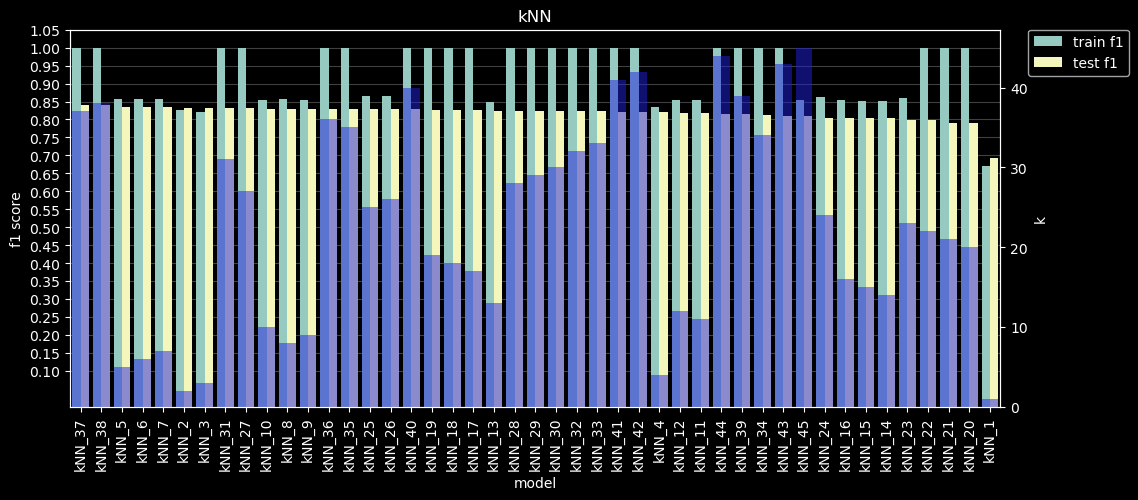

In [15]:
# Check train/test performance
model_ = kNN_df

# train/test
temp = model_[['model', 'simple_f1_tr', 'simple_f1_te']]
temp = temp.sort_values('simple_f1_te', ascending=False)
temp.rename({'simple_f1_tr': 'train f1', 'simple_f1_te': 'test f1'}, inplace=True, axis=1)
temp = temp.melt(id_vars='model')
# k
temp2 = model_[['model', 'k', 'simple_f1_te']]
temp2 = temp2.sort_values('simple_f1_te', ascending=False)

# Plot
fig, ax1 = plt.subplots(figsize=(12,5))

# 1st graph
g = sns.barplot(temp.model, temp.value, hue=temp.variable, ax=ax1)
ax1.set_ylabel('f1 score')
ax1.set_ylim(0,1)
ax1.set_yticks(np.arange(0.1,1.1,0.05))
ax1.grid(color='gray', alpha=.5, axis='y')
ax1.tick_params(labelrotation=90, axis='x')
ax1.legend(loc=7)
ax2 = ax1.twinx()
ax1.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

# 2nd graph
h = sns.barplot(temp2.model, temp2.k, color='b', alpha=.5, ax=ax2)
ax2.set_ylabel('k')

plt.title('kNN')
plt.show()

A lot of models are overfitting (train = 1). Model kNN_5 with 5 features performs better than the full model with 45 features while decreasing the complexity significantly.   
kNN_2 and kNN_3 are close to kNN_5 and perform also better than the full model.
(f1 test score = 0.83 vs 0.81)

In [16]:
kNN_df.loc[(kNN_df['model'] == 'kNN_5') |
           (kNN_df['model'] == 'kNN_45') |
           (kNN_df['model'] == 'kNN_2') |
           (kNN_df['model'] == 'kNN_3')][['model', 'k', 'simple_f1_tr', 'simple_f1_te']]

,model,k,simple_f1_tr,simple_f1_te
1,kNN_2,2,0.827175,0.832536
2,kNN_3,3,0.821429,0.831683
4,kNN_5,5,0.855643,0.834225
44,kNN_45,45,0.853625,0.808989


## Random Forest

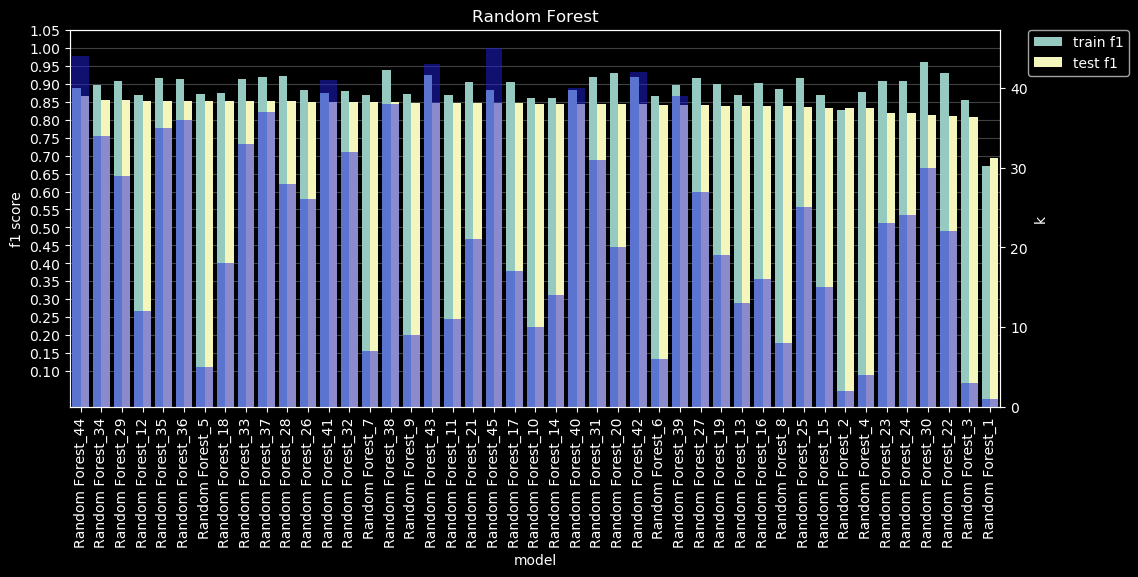

In [18]:
# Check train/test performance
model_ = rf_df

# train/test
temp = model_[['model', 'simple_f1_tr', 'simple_f1_te']]
temp = temp.sort_values('simple_f1_te', ascending=False)
temp.rename({'simple_f1_tr': 'train f1', 'simple_f1_te': 'test f1'}, inplace=True, axis=1)
temp = temp.melt(id_vars='model')
# k
temp2 = model_[['model', 'k', 'simple_f1_te']]
temp2 = temp2.sort_values('simple_f1_te', ascending=False)

# Plot
fig, ax1 = plt.subplots(figsize=(12,5))

# 1st graph
g = sns.barplot(temp.model, temp.value, hue=temp.variable, ax=ax1)
ax1.set_ylabel('f1 score')
ax1.set_ylim(0,1)
ax1.set_yticks(np.arange(0.1,1.1,0.05))
ax1.grid(color='gray', alpha=.5, axis='y')
ax1.tick_params(labelrotation=90, axis='x')
ax1.legend(loc=7)
ax2 = ax1.twinx()
ax1.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

# 2nd graph
h = sns.barplot(temp2.model, temp2.k, color='b', alpha=.5, ax=ax2)
ax2.set_ylabel('k')

plt.title('Random Forest')
plt.show()

In [17]:
rf_df.loc[(rf_df['model'] == 'Random Forest_3') | (rf_df['model'] == 'Random Forest_45')][['model', 'k', 'simple_f1_tr', 'simple_f1_te']]

,model,k,simple_f1_tr,simple_f1_te
2,Random Forest_3,3,0.853598,0.807882
44,Random Forest_45,45,0.882653,0.845361


## Logistic Regression

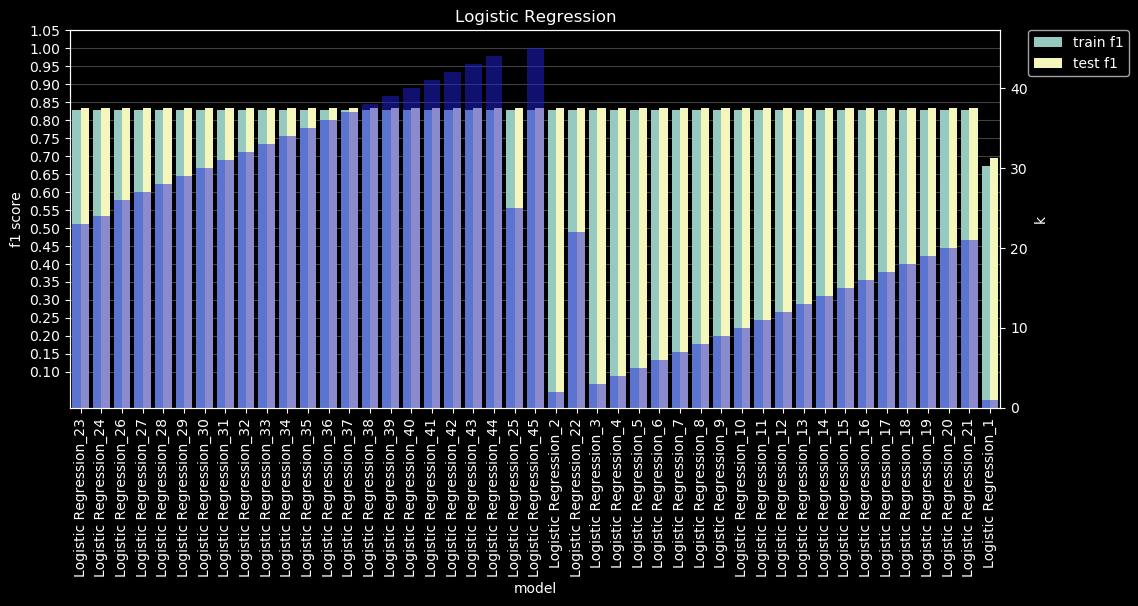

In [19]:
# Check train/test performance
model_ = lr_df

# train/test
temp = model_[['model', 'simple_f1_tr', 'simple_f1_te']]
temp = temp.sort_values('simple_f1_te', ascending=False)
temp.rename({'simple_f1_tr': 'train f1', 'simple_f1_te': 'test f1'}, inplace=True, axis=1)
temp = temp.melt(id_vars='model')
# k
temp2 = model_[['model', 'k', 'simple_f1_te']]
temp2 = temp2.sort_values('simple_f1_te', ascending=False)

# Plot
fig, ax1 = plt.subplots(figsize=(12,5))

# 1st graph
g = sns.barplot(temp.model, temp.value, hue=temp.variable, ax=ax1)
ax1.set_ylabel('f1 score')
ax1.set_ylim(0,1)
ax1.set_yticks(np.arange(0.1,1.1,0.05))
ax1.grid(color='gray', alpha=.5, axis='y')
ax1.tick_params(labelrotation=90, axis='x')
ax1.legend(loc=7)
ax2 = ax1.twinx()
ax1.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

# 2nd graph
h = sns.barplot(temp2.model, temp2.k, color='b', alpha=.5, ax=ax2)
ax2.set_ylabel('k')

plt.title('Logistic Regression')
plt.show()

In [20]:
lr_df.loc[(lr_df['model'] == 'Logistic Regression_23') | (lr_df['model'] == 'Logistic Regression_45')][['model', 'k', 'simple_f1_tr', 'simple_f1_te']]

,model,k,simple_f1_tr,simple_f1_te
22,Logistic Regression_23,23,0.827175,0.832536
44,Logistic Regression_45,45,0.827175,0.832536


Performance is exactly the same, regardless of the number of features chosen, as long as k>1. We can clearly see here that Logistic Regression is not using the features we are providing. It based itself mainly on `carts` and `checkouts`.

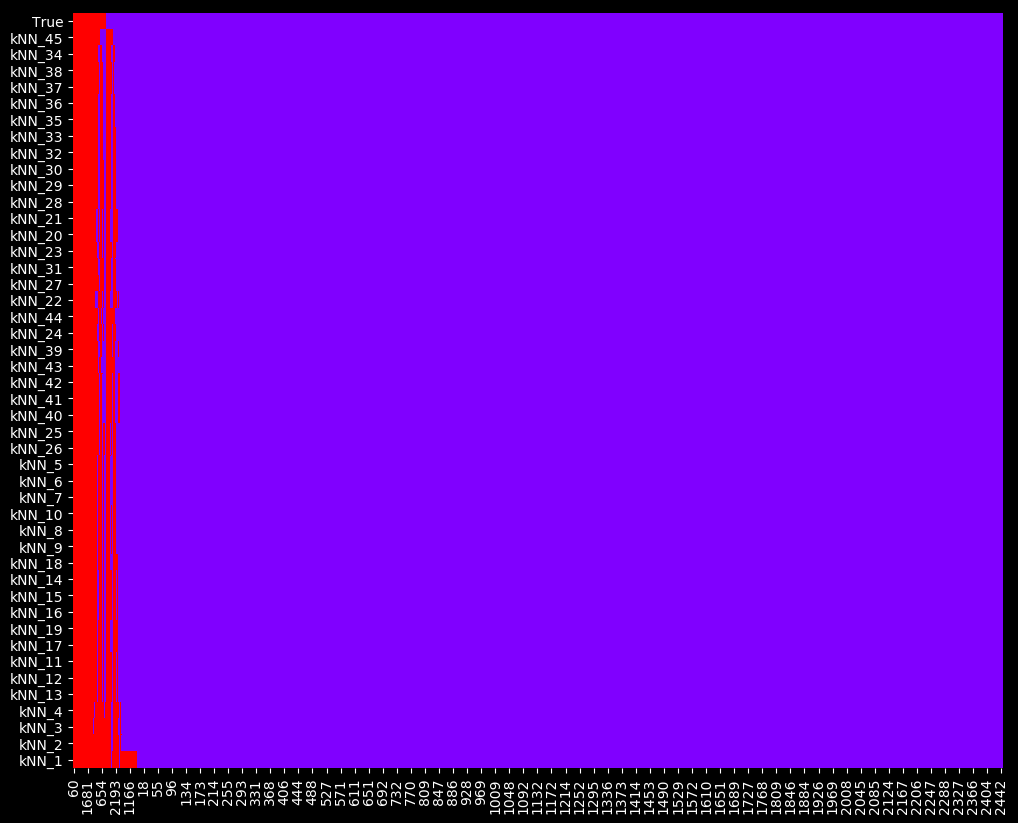

In [21]:
# Prediction Grid

# Index
ls = list(kNN_df['model'])
ls.insert(0, 'True')

# Grid
prediction_grid = pd.DataFrame(np.array(np.vstack((y_te, np.vstack(kNN_df['simple_pred'])))), index=ls)
# Reindex with minimum values of category '1'
prediction_grid = prediction_grid.reindex(prediction_grid.sum(axis=1).sort_values().index.to_list())
# Sort
prediction_grid = prediction_grid.T.sort_values(by=prediction_grid.index.tolist(), ascending=False).T

plt.figure(figsize=(12,10))
sns.heatmap(prediction_grid, cmap='rainbow', cbar=False)
plt.show()

In [ ]:
# Prediction Grid

# Index
ls = list(rf_df['model'])
ls.insert(0, 'True')

# Grid
prediction_grid = pd.DataFrame(np.array(np.vstack((y_te, np.vstack(rf_df['simple_pred'])))), index=ls)
# Reindex with minimum values of category '1'
prediction_grid = prediction_grid.reindex(prediction_grid.sum(axis=1).sort_values().index.to_list())
# Sort
prediction_grid = prediction_grid.T.sort_values(by=prediction_grid.index.tolist(), ascending=False).T

plt.figure(figsize=(12,10))
sns.heatmap(prediction_grid, cmap='rainbow', cbar=False)
plt.show()

In [ ]:
# Prediction Grid

# Index
ls = list(lr_df['model'])
ls.insert(0, 'True')

# Grid
prediction_grid = pd.DataFrame(np.array(np.vstack((y_te, np.vstack(lr_df['simple_pred'])))), index=ls)
# Reindex with minimum values of category '1'
prediction_grid = prediction_grid.reindex(prediction_grid.sum(axis=1).sort_values().index.to_list())
# Sort
prediction_grid = prediction_grid.T.sort_values(by=prediction_grid.index.tolist(), ascending=False).T

plt.figure(figsize=(12,10))
sns.heatmap(prediction_grid, cmap='rainbow', cbar=False)
plt.show()